In [2]:
# Cell 1: Imports and Environment Setup
import os
import json
from typing import Dict, List, Any, TypedDict
from datetime import datetime
from dotenv import load_dotenv
from langchain_groq import ChatGroq
from langchain_core.prompts import ChatPromptTemplate
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langgraph.graph import StateGraph, END
from googleapiclient.discovery import build
import wikipedia
import glob


In [3]:

# Load environment variables
load_dotenv()
print("✅ All imports loaded successfully!")
print("🔑 Environment check:")
print(f"   GROQ_API_KEY: {'✅ Found' if os.getenv('GROQ_API_KEY') else '❌ Missing'}")
print(f"   TAVILY_API_KEY: {'✅ Found' if os.getenv('TAVILY_API_KEY') else '❌ Missing'}")
print(f"   YOUTUBE_API_KEY: {'✅ Found' if os.getenv('YOUTUBE_API_KEY') else '❌ Missing'}")

✅ All imports loaded successfully!
🔑 Environment check:
   GROQ_API_KEY: ✅ Found
   TAVILY_API_KEY: ✅ Found
   YOUTUBE_API_KEY: ✅ Found


In [4]:
# Cell 2: Define A2A Message and ResearchState
class A2AMessage(TypedDict):
    sender: str
    receiver: str
    intent: str
    data: Any
    timestamp: str

class ResearchState(TypedDict):
    query: str
    messages: List[A2AMessage]
    conversation_history: List[Dict[str, str]]
    final_answer: str

In [5]:
# Cell 3: Initialize LLM and Tools
# Initialize LLM
llm = ChatGroq(model="llama-3.3-70b-versatile", temperature=0.7)

# Initialize tools
tavily_tool = TavilySearchResults(max_results=3)
embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")
text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)

# Function to load documents
def load_documents(doc_path: str = "./data.txt") -> List[str]:
    documents = []
    for file_path in glob.glob(doc_path):
        try:
            with open(file_path, 'r', encoding='utf-8') as file:
                documents.append(file.read())
        except Exception as e:
            print(f"Error loading {file_path}: {str(e)}")
    if not documents:
        print("Warning: No documents found, using fallback content")
        documents = ["Sample document content about AI research..."]
    return documents

# Create FAISS vector store
try:
    documents = load_documents()
    chunks = [chunk for doc in documents for chunk in text_splitter.split_text(doc)]
    vector_store = FAISS.from_texts(chunks, embeddings)
    print("✅ FAISS vector store initialized successfully")
except Exception as e:
    print(f"Error initializing FAISS: {str(e)}")

/var/folders/tv/6v878xl54ljbbwhlvpn95qnh0000gn/T/ipykernel_22498/3762813552.py:6: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tavily_tool = TavilySearchResults(max_results=3)
/var/folders/tv/6v878xl54ljbbwhlvpn95qnh0000gn/T/ipykernel_22498/3762813552.py:7: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(model_n

✅ FAISS vector store initialized successfully


In [6]:
# Cell 4: Define Prompts
from langchain_core.prompts import ChatPromptTemplate

planner_prompt = ChatPromptTemplate.from_template("""
You are a planner agent coordinating a research task. Your role is to analyze the user query and conversation history, then select 1-2 relevant sub-agents to delegate tasks to. Available agents are:
- tavily: For real-time web searches on recent trends or news (e.g., "latest trends in renewable energy").
- youtube: For video content or tutorials (provide a specific search term, e.g., "renewable energy trends 2025").
- wikipedia: For factual, encyclopedic information (e.g., "what is solar energy").
- rag: For searching local documents in a FAISS vector store (e.g., "renewable energy data from documents").

**Instructions**:
1. Analyze the query's intent to determine the most relevant agent(s).
2. Select 1-2 agents based on the query's focus:
   - Use 'tavily' for recent trends, news, or broad web searches.
   - Use 'youtube' for how-to guides or visual content.
   - Use 'wikipedia' for definitions or general knowledge.
   - Use 'rag' for document-specific insights.
3. For YouTube, provide a specific search term derived from the query.
4. Output a JSON list of 1-2 tasks in the format:
   [
       {"sender": "planner", "receiver": "agent_name", "intent": "search", "data": "specific task or query", "timestamp": "{current_time}"}
   ]
5. Return *only* valid JSON, without code block markers (```json

**Query**: {query}
**Conversation History**: {history}
**Current Time**: {current_time}

**Example for "latest trends in renewable energy"**:
[
    {"sender": "planner", "receiver": "tavily", "intent": "search", "data": "latest trends in renewable energy 2025", "timestamp": "{current_time}"},
    {"sender": "planner", "receiver": "youtube", "intent": "search", "data": "renewable energy trends 2025", "timestamp": "{current_time}"}
]
""")

summarizer_prompt = ChatPromptTemplate.from_template("""
You are a summarizer agent. Combine results from multiple agents into a concise, coherent answer (max 200 words). Ensure the response is factual, relevant to the query, and integrates all provided information. If agent results are missing or contain errors, note the limitation briefly and provide a general answer based on common knowledge.

**Query**: {query}
**Agent Results**: {results}
**Conversation History**: {history}
""")

In [7]:
import re
from datetime import datetime
import json

def planner_node(state: dict) -> dict:
    history = "\n".join([f"{msg['role']}: {msg['content']}" for msg in state["conversation_history"]])
    current_time = datetime.now().isoformat()
    try:
        formatted_prompt = planner_prompt.format(
            query=state["query"],
            history=history,
            current_time=current_time
        )
        print(f"Planner Prompt: {formatted_prompt}")  # Debug: Inspect prompt
        response = llm.invoke(formatted_prompt)
        response_text = response.content.strip()
        print(f"Planner LLM Response: {response_text}")  # Debug: Inspect raw response

        # Clean response: remove code block markers, comments, and extra whitespace
        response_text = re.sub(r'^```(?:json)?\s*\n|\s*```$', '', response_text, flags=re.MULTILINE)
        response_text = re.sub(r'//.*?\n|/\*.*?\*/', '', response_text, flags=re.DOTALL)
        response_text = response_text.strip()

        if not response_text:
            raise ValueError("Empty response after cleaning")

        messages = json.loads(response_text)
        if not isinstance(messages, list):
            raise ValueError("Planner output must be a JSON list")

        valid_receivers = {"tavily", "youtube", "wikipedia", "rag"}
        messages = [msg for msg in messages if msg.get("receiver") in valid_receivers]
        if not messages:
            print("No valid tools selected, defaulting to tavily, youtube, and wikipedia")
            messages = [
                {
                    "sender": "planner",
                    "receiver": "tavily",
                    "intent": "search",
                    "data": f"{state['query']} 2025",
                    "timestamp": current_time
                },
                {
                    "sender": "planner",
                    "receiver": "youtube",
                    "intent": "search",
                    "data": f"{state['query']} 2025",
                    "timestamp": current_time
                },
                {
                    "sender": "planner",
                    "receiver": "wikipedia",
                    "intent": "search",
                    "data": f"{state['query']}",
                    "timestamp": current_time
                }
            ]
        return {"messages": state["messages"] + messages}
    except Exception as e:
        print(f"Planner Answer: ")
        return {
            "messages": state["messages"] + [
                {
                    "sender": "planner",
                    "receiver": "tavily",
                    "intent": "search",
                    "data": f"{state['query']} 2025",
                    "timestamp": current_time
                },
                {
                    "sender": "planner",
                    "receiver": "youtube",
                    "intent": "search",
                    "data": f"{state['query']} 2025",
                    "timestamp": current_time
                },
                {
                    "sender": "planner",
                    "receiver": "wikipedia",
                    "intent": "search",
                    "data": f"{state['query']}",
                    "timestamp": current_time
                },
                {
                    "sender": "planner",
                    "receiver": "summarizer",
                    "intent": "error",
                    "data": f"Planner failed: {str(e)}",
                    "timestamp": current_time
                }
            ]
        }

In [9]:
#  tavily_agent 
def tavily_agent(state: ResearchState) -> Dict[str, Any]:
    current_time = datetime.now().isoformat()
    results = []
    for msg in state["messages"]:
        if msg["receiver"] == "tavily" and msg["intent"] == "search":
            try:
                print(f"Running Tavily search for: {msg['data']}")  # Debug
                search_results = tavily_tool.run(msg["data"])
                if not search_results:
                    raise Exception("No results returned from Tavily")
                results.append({
                    "sender": "tavily",
                    "receiver": "summarizer",
                    "intent": "results",
                    "data": search_results,
                    "timestamp": current_time
                })
            except Exception as e:
                print(f"Tavily error: {str(e)}")  # Debug
                results.append({
                    "sender": "tavily",
                    "receiver": "summarizer",
                    "intent": "error",
                    "data": f"Tavily search failed: {str(e)}",
                    "timestamp": current_time
                })
    print(f"Tavily results: {results}")  # Debug
    return {"messages": state["messages"] + results}

In [10]:
pip install youtube_transcript_api

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


In [11]:
from youtube_transcript_api import YouTubeTranscriptApi
from googleapiclient.discovery import build

def youtube_agent(state: dict) -> dict:
    current_time = datetime.now().isoformat()
    results = []
    for msg in state["messages"]:
        if msg["receiver"] == "youtube" and msg["intent"] == "search":
            try:
                # Search YouTube
                youtube = build("youtube", "v3", developerKey=os.environ["YOUTUBE_API_KEY"])
                request = youtube.search().list(q=msg["data"], part="snippet", maxResults=1, type="video")
                response = request.execute()
                if not response["items"]:
                    raise Exception("No videos found")
                video_id = response["items"][0]["id"]["videoId"]
                video_title = response["items"][0]["snippet"]["title"]
                
                # Fetch and summarize transcript
                try:
                    transcript = YouTubeTranscriptApi.get_transcript(video_id)
                    transcript_text = " ".join([entry["text"] for entry in transcript])
                    # Limit to 2000 characters to avoid LLM token limits
                    summary_prompt = f"Summarize the following transcript in 100 words or less, focusing on key points relevant to '{msg['data']}':\n{transcript_text[:2000]}"
                    summary_response = llm.invoke(summary_prompt)
                    summary = summary_response.content.strip()
                    result = f"Video: {video_title} (ID: {video_id})\nSummary: {summary}"
                except Exception as e:
                    result = f"Video: {video_title} (ID: {video_id})\nTranscript unavailable: {str(e)}"
                
                results.append({
                    "sender": "youtube",
                    "receiver": "summarizer",
                    "intent": "results",
                    "data": result,
                    "timestamp": current_time
                })
            except Exception as e:
                results.append({
                    "sender": "youtube",
                    "receiver": "summarizer",
                    "intent": "error",
                    "data": f"YouTube search failed: {str(e)}",
                    "timestamp": current_time
                })
    return {"messages": state["messages"] + results}

In [12]:
def wikipedia_agent(state: ResearchState) -> Dict[str, Any]:
    current_time = datetime.now().isoformat()
    results = []
    for msg in state["messages"]:
        if msg["receiver"] == "wikipedia" and msg["intent"] == "search":
            try:
                result = wikipedia.summary(msg["data"], sentences=3)
                results.append({
                    "sender": "wikipedia",
                    "receiver": "summarizer",
                    "intent": "results",
                    "data": result,
                    "timestamp": current_time
                })
            except Exception as e:
                results.append({
                    "sender": "wikipedia",
                    "receiver": "summarizer",
                    "intent": "error",
                    "data": f"Wikipedia search failed: {str(e)}",
                    "timestamp": current_time
                })
    return {"messages": state["messages"] + results}



In [13]:
def rag_agent(state: ResearchState) -> Dict[str, Any]:
    current_time = datetime.now().isoformat()
    results = []
    for msg in state["messages"]:
        if msg["receiver"] == "rag" and msg["intent"] == "search":
            try:
                search_results = vector_store.similarity_search(msg["data"], k=3)
                results.append({
                    "sender": "rag",
                    "receiver": "summarizer",
                    "intent": "results",
                    "data": [doc.page_content for doc in search_results],
                    "timestamp": current_time
                })
            except Exception as e:
                results.append({
                    "sender": "rag",
                    "receiver": "summarizer",
                    "intent": "error",
                    "data": f"RAG search failed: {str(e)}",
                    "timestamp": current_time
                })
    return {"messages": state["messages"] + results}



In [14]:
def summarizer_agent(state: ResearchState) -> Dict[str, Any]:
    results = [msg["data"] for msg in state["messages"] if msg["receiver"] == "summarizer" and msg["intent"] in ["results", "error"]]
    history = "\n".join([f"{msg['role']}: {msg['content']}" for msg in state["conversation_history"]])
    formatted_prompt = summarizer_prompt.format(
        query=state["query"],
        results=json.dumps(results),
        history=history
    )
    try:
        response = llm.invoke(formatted_prompt)
        final_answer = response.content.strip()
    except Exception as e:
        final_answer = f"Error in summarization: {str(e)}"
    return {"final_answer": final_answer}

In [15]:
# Cell 6: Define LangGraph Workflow
# Replace route_to_tool in Cell 6
def route_to_tool(state: ResearchState) -> str:
    """Route to the next unprocessed tool or summarizer."""
    messages = state["messages"]
    if not messages:
        return "summarizer"
    # Find unprocessed planner messages
    for msg in messages:
        if msg["sender"] == "planner" and msg["intent"] == "search":
            receiver = msg["receiver"]
            if receiver in {"tavily", "youtube", "wikipedia", "rag"}:
                # Check if this tool has already responded
                has_response = any(m["sender"] == receiver and m["intent"] in ["results", "error"] for m in messages)
                if not has_response:
                    print(f"Routing to: {receiver}")  # Debug
                    return receiver
    print("Routing to: summarizer")  # Debug
    return "summarizer"

workflow = StateGraph(ResearchState)
workflow.add_node("planner", planner_node)
workflow.add_node("tavily", tavily_agent)
workflow.add_node("youtube", youtube_agent)
workflow.add_node("wikipedia", wikipedia_agent)
workflow.add_node("rag", rag_agent)
workflow.add_node("summarizer", summarizer_agent)
workflow.set_entry_point("planner")

# Conditional routing from planner
workflow.add_conditional_edges("planner", route_to_tool, {
    "tavily": "tavily",
    "youtube": "youtube",
    "wikipedia": "wikipedia",
    "rag": "rag",
    "summarizer": "summarizer"
})

# Each tool goes to summarizer
workflow.add_edge("tavily", "summarizer")
workflow.add_edge("youtube", "summarizer")
workflow.add_edge("wikipedia", "summarizer")
workflow.add_edge("rag", "summarizer")
workflow.add_edge("summarizer", END)

app = workflow.compile()
print("✅ Workflow compiled successfully!")

✅ Workflow compiled successfully!


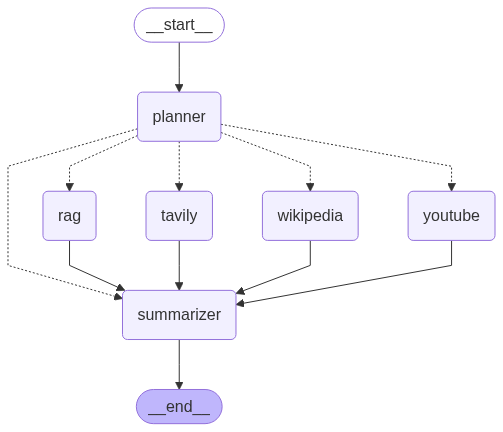

In [16]:

from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [17]:
def run_research(query: str, history: List[Dict[str, str]] = None) -> tuple[str, List[Dict[str, str]]]:
    initial_state = {
        "query": query,
        "messages": [],
        "conversation_history": history or [],
        "final_answer": ""
    }
    result = app.invoke(initial_state)
    print("A2A Messages:", json.dumps(result["messages"], indent=2))
    print("Final State:", json.dumps({k: v for k, v in result.items() if k != "messages"}, indent=2))
    # Update history
    result["conversation_history"].append({"role": "user", "content": query})
    result["conversation_history"].append({"role": "assistant", "content": result["final_answer"]})
    return result["final_answer"], result["conversation_history"]

In [18]:
# Cell 8: Test the System
query = "What are the latest trends in renewable energy?"
answer = run_research(query)
print(f"Query: {query}\nAnswer: {answer}")

Planner Answer: 
Routing to: tavily
Running Tavily search for: What are the latest trends in renewable energy? 2025
Tavily results: [{'sender': 'tavily', 'receiver': 'summarizer', 'intent': 'results', 'data': [{'title': '2025 Renewable Energy Industry Outlook | Deloitte Insights', 'url': 'https://www.deloitte.com/us/en/insights/industry/renewable-energy/renewable-energy-industry-outlook.html', 'content': '### Share image\n\n### Or copy link\n\nDeloitte’s Renewable Energy Industry Outlook draws on insights from our 2024 power and utilities survey, along with analysis of industrial policy, tech capital, new technologies, workforce development, and carbon management, to understand how the new competitive landscape may drive renewables growth amid an infrastructural buildout in the cleantech, AI, and carbon markets.\n\nFive key trends to watch in 2025 include:\n\n### Share image\n\n### Or copy link [...] maturity, low cost, and high modularity. Domestic supply chains, AI acceleration of op

In [19]:
# Cell 8: Test the System
history = []
query1 = "What are the latest trends in renewable energy?"
answer1, history = run_research(query1, history)
print(f"Query 1: {query1}\nAnswer: {answer1}\n")

query2 = "More details on solar energy trends"
answer2, history = run_research(query2, history)
print(f"Query 2: {query2}\nAnswer: {answer2}\n")
print("Conversation History:", json.dumps(history, indent=2))

Planner Answer: 
Routing to: tavily
Running Tavily search for: What are the latest trends in renewable energy? 2025
Tavily results: [{'sender': 'tavily', 'receiver': 'summarizer', 'intent': 'results', 'data': [{'title': '2025 Renewable Energy Industry Outlook | Deloitte Insights', 'url': 'https://www.deloitte.com/us/en/insights/industry/renewable-energy/renewable-energy-industry-outlook.html', 'content': '### Share image\n\n### Or copy link\n\nDeloitte’s Renewable Energy Industry Outlook draws on insights from our 2024 power and utilities survey, along with analysis of industrial policy, tech capital, new technologies, workforce development, and carbon management, to understand how the new competitive landscape may drive renewables growth amid an infrastructural buildout in the cleantech, AI, and carbon markets.\n\nFive key trends to watch in 2025 include:\n\n### Share image\n\n### Or copy link [...] maturity, low cost, and high modularity. Domestic supply chains, AI acceleration of op

In [20]:
# Cell 8: Test the System
query = "What is cricket "
answer = run_research(query)
print(f"Query: {query}\nAnswer: {answer}")

Planner Answer: 
Routing to: tavily
Running Tavily search for: What is cricket  2025
Tavily results: [{'sender': 'tavily', 'receiver': 'summarizer', 'intent': 'results', 'data': [{'title': 'International cricket in 2025–26 - Wikipedia', 'url': 'https://en.wikipedia.org/wiki/International_cricket_in_2025%E2%80%9326', 'content': "| International cricket |\n| --- |\n| _in 2025_ | _in 2026_ |\n\nThe 2025–26 International cricket season is scheduled to take place from September 2025 to March 2026.( This calendar includes men's Test, ODI and T20I matches between full member teams, women's Test, ODI and T20I matches, as well as some other significant series.( [...] |  v  t  e International cricket in 2025–26 |\n| --- |\n| Preceding season: International cricket in 2025 |\n| September 2025 |  Asia Cup  Australia women in India  Women's Cricket World Cup |\n| October 2025 |  West Indies in India  South Africa in Namibia  India in Australia  West Indies in Bangladesh |\n| November 2025 |  South 